In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import jax
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Couplings J1 and J2
J = [1, 0.2]
L = 8

In [3]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])
# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),  
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)

In [4]:
op = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)

In [5]:
import netket.nn as nknn
import flax.linen as nn
import jax.numpy as jnp

class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], 
                     use_bias=True, 
                     param_dtype=np.complex128, 
                     kernel_init=nn.initializers.normal(stddev=0.01), 
                     bias_init=nn.initializers.normal(stddev=0.01)
                    )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x

model = FFNN()

In [6]:
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max = 2)
vs = nk.vqs.MCState(sa, model, n_samples=1008)
opt = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.01)
gs = nk.VMC(hamiltonian=op, optimizer=opt, variational_state=vs, preconditioner=sr)

In [7]:
vs

MCState(
  hilbert = Spin(s=1/2, total_sz=0.0, N=8),
  sampler = MetropolisSampler(rule = ExchangeRule(# of clusters: 28), n_chains = 16, sweep_size = 8, reset_chains = False, machine_power = 2, dtype = <class 'float'>),
  n_samples = 1008,
  n_discard_per_chain = 100,
  sampler_state = MetropolisSamplerState(rng state=[2884847178 1803461318]),
  n_parameters = 144)

In [17]:
vs_i_parameters = vs.parameters.copy()

In [18]:
vs_i_parameters['Dense_0']['bias']

Array([ 0.01015423-0.00759328j,  0.01114902-0.00910018j,
        0.00202281+0.00067481j,  0.00461645+0.00566972j,
        0.01230939-0.01161218j, -0.0094413 +0.01060325j,
        0.00399605+0.00864876j, -0.00578464+0.0001741j ,
        0.00806847-0.00763409j,  0.00809708-0.00459213j,
        0.00125037+0.00841867j,  0.00526244-0.00314228j,
       -0.00616233+0.00230532j, -0.00888735-0.00568256j,
        0.007714  -0.01552738j,  0.01041586+0.00602959j],      dtype=complex128)

In [20]:
# Define a função de perda (loss function) para o treinamento
def loss(params, structure_factor):
    output = model.apply({'params': params}, structure_factor)
    return jnp.mean(output)
# Função de callback para salvar os parâmetros durante o treinamento
def save_params(step, params, energy):
    trained_params_list.append(params.copy())
    parameters_list.append(energy.state.parameters.copy())
    iii.append(1)
    return True

In [21]:
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j))*((-1)**(i-j))/L

# Define uma lista para armazenar os parâmetros do modelo durante o treinamento
trained_params_list = []
parameters_list     = []
iii                 = []

In [22]:
gs.run(out='test', n_iter=300, obs={'Structure Factor': structure_factor}, callback=save_params)

100%|██| 300/300 [00:28<00:00, 10.48it/s, Energy=-13.40285+0.00028j ± 0.00048 [σ²=0.00023, R̂=1.0071]]


(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.1033620834350586
   	Params: 0.09069442749023438,)

In [23]:
vs.parameters['Dense_0']['bias']

Array([ 5.13200901e-03+0.00019323j,  2.22363492e-03+0.00055872j,
        1.12152679e-03+0.00037886j,  4.53394114e-03+0.00050117j,
        6.58555255e-03+0.00125517j, -3.32480422e-03+0.00726544j,
        9.01720953e-05+0.00159352j,  1.38748592e-03+0.00114699j,
        3.12590328e-03+0.00274978j, -7.14637818e-05-0.00294614j,
        1.14715862e-03+0.00047066j,  2.63945431e-03+0.00044031j,
        1.51922646e-03+0.00036613j, -2.96645580e-03+0.00233363j,
        2.33308923e-03-0.00341041j,  5.14134309e-03+0.00208888j],      dtype=complex128)

In [25]:
len(parameters_list)

300

In [26]:
parameters_list[299]['Dense_0']['bias']

Array([ 5.13625101e-03+0.00017109j,  2.23578669e-03+0.00056511j,
        1.11385335e-03+0.0003738j ,  4.55663806e-03+0.00050241j,
        6.58600685e-03+0.00123341j, -3.33647465e-03+0.00728987j,
        1.05326494e-04+0.0015803j ,  1.39995455e-03+0.00114936j,
        3.13967392e-03+0.00274054j, -8.16921587e-05-0.00295458j,
        1.17375985e-03+0.00045047j,  2.64764692e-03+0.00043295j,
        1.49770299e-03+0.00037758j, -2.98208311e-03+0.00234116j,
        2.35462458e-03-0.00343176j,  5.16760553e-03+0.00209346j],      dtype=complex128)

In [24]:
parameters_list[-1]['Dense_0']['bias']

Array([ 5.13625101e-03+0.00017109j,  2.23578669e-03+0.00056511j,
        1.11385335e-03+0.0003738j ,  4.55663806e-03+0.00050241j,
        6.58600685e-03+0.00123341j, -3.33647465e-03+0.00728987j,
        1.05326494e-04+0.0015803j ,  1.39995455e-03+0.00114936j,
        3.13967392e-03+0.00274054j, -8.16921587e-05-0.00295458j,
        1.17375985e-03+0.00045047j,  2.64764692e-03+0.00043295j,
        1.49770299e-03+0.00037758j, -2.98208311e-03+0.00234116j,
        2.35462458e-03-0.00343176j,  5.16760553e-03+0.00209346j],      dtype=complex128)

In [28]:
def info(e):
    head   = list(e.keys())[0]
    body   = list(e[head].keys())
    bias   = e[head][body[0]]
    kernel = e[head][body[1]]
    return  head, body, list(bias), list(kernel)
def real(c):
    return float(np.real(c))  
def img(c):
    return float(np.imag(c))    
def r_i(c):
    return real(c),img(c)   

In [31]:
head, body, bias_list,kernel_list = info(parameters_list[-1])

In [51]:
len(bias_list)

16

In [54]:
i = 0
df = pd.DataFrame()
b_real = [];b_img = []
for bias in bias_list:
    nr, ni = r_i(bias); b_real.append(nr); b_img.append(ni); i = i +1
    v = []
    l = [index,nr,ni]
    v.append(l)
    dft = pd.DataFrame(v, columns=['real_bias', 'img_bias'])
    df = pd.concat([df,dft])

In [56]:
df.head(10)

,real_bias,img_bias
0,0.005136,0.000171
0,0.002236,0.000565
0,0.001114,0.000374
0,0.004557,0.000502
0,0.006586,0.001233
0,-0.003336,0.007290
0,0.000105,0.001580
0,0.001400,0.001149
0,0.003140,0.002741
0,-0.000082,-0.002955


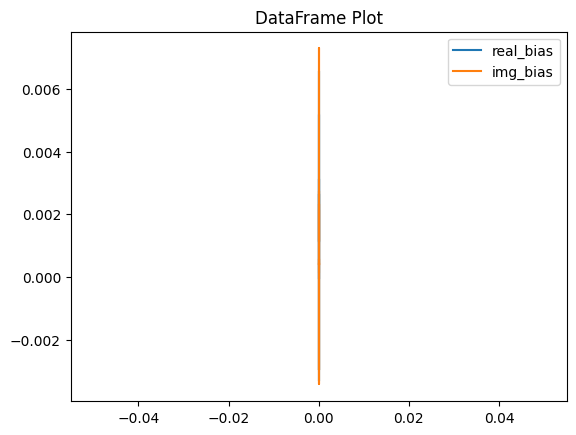

In [57]:
plot = df.plot(title="DataFrame Plot")

In [48]:
import pandas as pd


In [49]:
df.head()

,real_bias,img_bias
0,0.005168,0.002093


In [50]:
df.shape

(1, 2)

In [33]:
head, body

('Dense_0', ['bias', 'kernel'])

In [35]:
kernel_list

[Array([-0.14730769+0.03015666j, -0.01679665-0.1495097j ,
         0.15299642+0.08303733j, -0.10321546+0.20541964j,
         0.13718132-0.04386173j,  0.04018935+0.02203545j,
         0.06543846+0.06379955j, -0.08109256+0.0651634j ,
        -0.08490057-0.1014249j ,  0.01506866-0.0969116j ,
         0.039123  +0.06146279j,  0.04310922-0.19203219j,
        -0.00939811+0.24920995j, -0.1189488 -0.1760611j ,
         0.02287901-0.07579586j,  0.03342548-0.12097328j],      dtype=complex128),
 Array([ 0.0880107 +0.01091408j, -0.01866174-0.08555553j,
        -0.11852278+0.19732148j,  0.08663299+0.154856j  ,
        -0.09228743-0.16281054j, -0.05821577+0.01990454j,
        -0.05589892-0.03401436j,  0.03647514-0.08576608j,
         0.10582032-0.02044032j, -0.09268133-0.07057596j,
        -0.06226882-0.16942969j, -0.08552291-0.09594007j,
        -0.00554003+0.18783904j,  0.11911837-0.2422507j ,
         0.03070795-0.1880787j ,  0.02586905+0.02709379j],      dtype=complex128),
 Array([-0.00725164+0.

In [34]:
bias_list

[Array(0.00513625+0.00017109j, dtype=complex128),
 Array(0.00223579+0.00056511j, dtype=complex128),
 Array(0.00111385+0.0003738j, dtype=complex128),
 Array(0.00455664+0.00050241j, dtype=complex128),
 Array(0.00658601+0.00123341j, dtype=complex128),
 Array(-0.00333647+0.00728987j, dtype=complex128),
 Array(0.00010533+0.0015803j, dtype=complex128),
 Array(0.00139995+0.00114936j, dtype=complex128),
 Array(0.00313967+0.00274054j, dtype=complex128),
 Array(-8.16921587e-05-0.00295458j, dtype=complex128),
 Array(0.00117376+0.00045047j, dtype=complex128),
 Array(0.00264765+0.00043295j, dtype=complex128),
 Array(0.0014977+0.00037758j, dtype=complex128),
 Array(-0.00298208+0.00234116j, dtype=complex128),
 Array(0.00235462-0.00343176j, dtype=complex128),
 Array(0.00516761+0.00209346j, dtype=complex128)]